# AE Architectures Comparison

Notebook that explores multiple architectures with different number of layers and parameters.

In [49]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [50]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [51]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [52]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    mask_gamma_ray = np.array((data_noisy_all[1]==1))
    data_noisy_chunk = np.array(data_noisy_all[0])[mask_gamma_ray]
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])[mask_gamma_ray]
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(64*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(64*chunk_tot, 56, 56)


**Data Preperation**

In [53]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_binary = np.zeros((64*chunk_tot, 56, 56))
data_true_binary[data_true>threshold] = 1
data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
pix_max = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
pix_min = np.nanmin(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num((data_noisy_arr - pix_min)/(pix_max-pix_min))

data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())
data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]


In [54]:
# Batch form
batch_size = 16

N, H, W = data_noisy_train.shape
N_new = N//batch_size

data_noisy_train_batch = data_noisy_train[:int(N_new*batch_size)].reshape(N_new, batch_size, 1, H, W)
data_true_train_batch = data_true_train[:int(N_new*batch_size)].reshape(N_new, batch_size, H*W)

**The Autoencoder Models**

In [55]:
# AE with only 1 layer

class AE1(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder functions
        self.conv1 = nn.Conv2d(1, 100, kernel_size=(3,3))
        
        # Decoder functions
        self.deconv1 = nn.ConvTranspose2d(100, 1, kernel_size=(3,3))
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)  
            
        N = (x.shape)[0]
        
        # Encoder part
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = self.deconv1(x)
        x = F.relu(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x                 

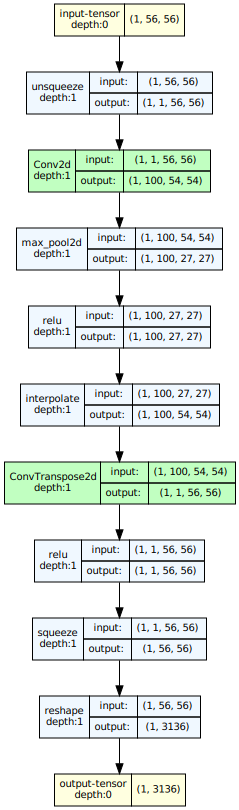

In [56]:
# Visualize the model
model_graph = draw_graph(AE1(), input_size=(1,56,56), expand_nested=True)
model_graph.visual_graph

In [57]:
# AE with 2 layers

class AE2(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 100
            
        # Encoder functions
        self.conv1 = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv2 = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1 = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2 = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = self.conv2(x)
        x = F.relu(F.max_pool2d(x, (2,2)))

        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = self.deconv1(x)
        x = F.relu(x)
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = self.deconv2(x)
        
        # Get the right shape
        x = x.squeeze(0)
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

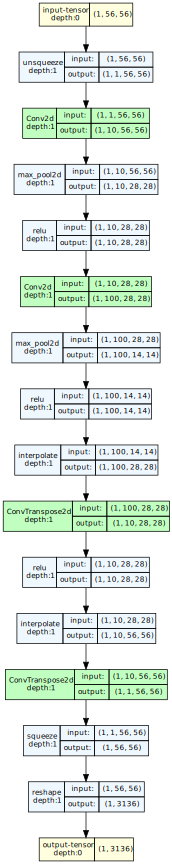

In [58]:
# Visualize the model
model_graph = draw_graph(AE2(), input_size=(1,56,56), expand_nested=True)
model_graph.visual_graph

In [59]:
# AE with 3 layers

class AE3(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 100
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 20, kernel_size=(3,3), padding='same')
        self.conv2 = nn.Conv2d(20, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1 = nn.ConvTranspose2d(second_layer, 20, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(20, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = self.conv2(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

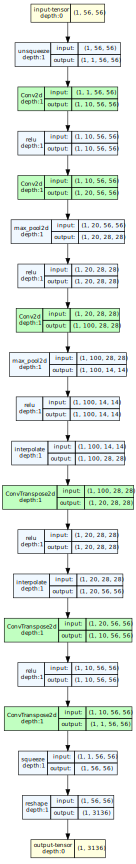

In [60]:
# Visualize the model
model_graph = draw_graph(AE3(), input_size=(1,56,56), expand_nested=True)
model_graph.visual_graph

In [61]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

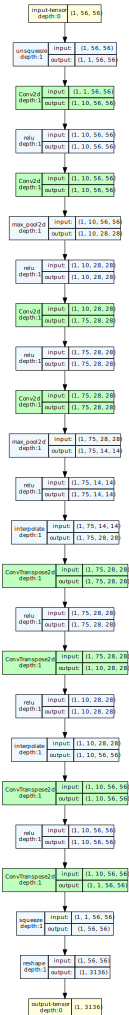

In [62]:
# Visualize the model
model_graph = draw_graph(AE4(), input_size=(1,56,56), expand_nested=True)
model_graph.visual_graph

In [63]:
print("Number of parameters AE1:")
print(sum(p.numel() for p in AE1().parameters() if p.requires_grad))
print()

print("Number of parameters AE2:")
print(sum(p.numel() for p in AE2().parameters() if p.requires_grad))
print()

print("Number of parameters AE3:")
print(sum(p.numel() for p in AE3().parameters() if p.requires_grad))
print()

print("Number of parameters AE4:")
print(sum(p.numel() for p in AE4().parameters() if p.requires_grad))

Number of parameters AE1:
1901

Number of parameters AE2:
18301

Number of parameters AE3:
39941

Number of parameters AE4:
116996


**Defining fitting functions**

In [64]:
# Function to calculate the intersection-over-union
def IOU_calc(clean_iou, true_iou): 
    clean_sum = torch.sum(clean_iou)
    true_sum = torch.sum(true_iou)
    true_iou2 = torch.zeros(true_iou.shape)
    
    true_iou2[true_iou==0] = 2 
    true_iou2[true_iou==1] = 1
    
    intersection_arr = (clean_iou==true_iou2)
    intersection_sum = torch.sum(intersection_arr)
    
    IOU = intersection_sum/(clean_sum+true_sum-intersection_sum)
    
    return IOU

In [65]:
# Functions and definitions for 
n_epochs = 15

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

weight = 2

batch_size = 16

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train_batch, data_true_train_batch):
        #noisy = noisy.unsqueeze(0)
        #true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            output_binary = output_data.round()
            pred = output.data.max(1, keepdim=True)[1]
            IOU += IOU_calc(output_binary, true)
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses.append(test_loss)
    IOU_list.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

In [66]:

test_losses_all = []
IOU_all = []

**1 layer**

In [67]:
%%time



learning_rate = 0.001

network = AE1()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*100 for i in range(n_epochs + 1)]
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)
IOU_all.append(IOU_list)


Test set: Avg. loss: 5.9927
IOU: 0.024988312274217606
Training set: Avg. loss: 0.7980

Test set: Avg. loss: 0.7124
IOU: 9.151642188953701e-06
Training set: Avg. loss: 0.7157

Test set: Avg. loss: 0.7112
IOU: 0.0
Training set: Avg. loss: 0.7153

Test set: Avg. loss: 0.7111
IOU: 0.0
Training set: Avg. loss: 0.7152

Test set: Avg. loss: 0.7110
IOU: 0.0
Training set: Avg. loss: 0.7152

Test set: Avg. loss: 0.7110
IOU: 0.0
Training set: Avg. loss: 0.7151

Test set: Avg. loss: 0.7110
IOU: 0.0
Training set: Avg. loss: 0.7151

Test set: Avg. loss: 0.7110
IOU: 0.0
Training set: Avg. loss: 0.7151

Test set: Avg. loss: 0.7110
IOU: 0.0
Training set: Avg. loss: 0.7151

Test set: Avg. loss: 0.7109
IOU: 0.0
Training set: Avg. loss: 0.7151

Test set: Avg. loss: 0.7109
IOU: 0.0
Training set: Avg. loss: 0.7151

Test set: Avg. loss: 0.7109
IOU: 0.0
Training set: Avg. loss: 0.7151

Test set: Avg. loss: 0.7109
IOU: 0.0
Training set: Avg. loss: 0.7151

Test set: Avg. loss: 0.7109
IOU: 0.0
Training set: Avg

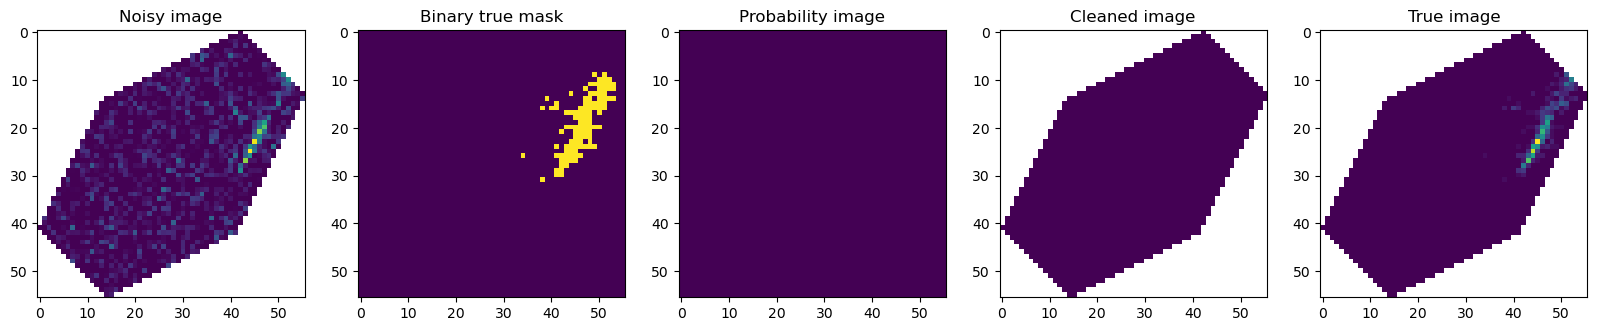

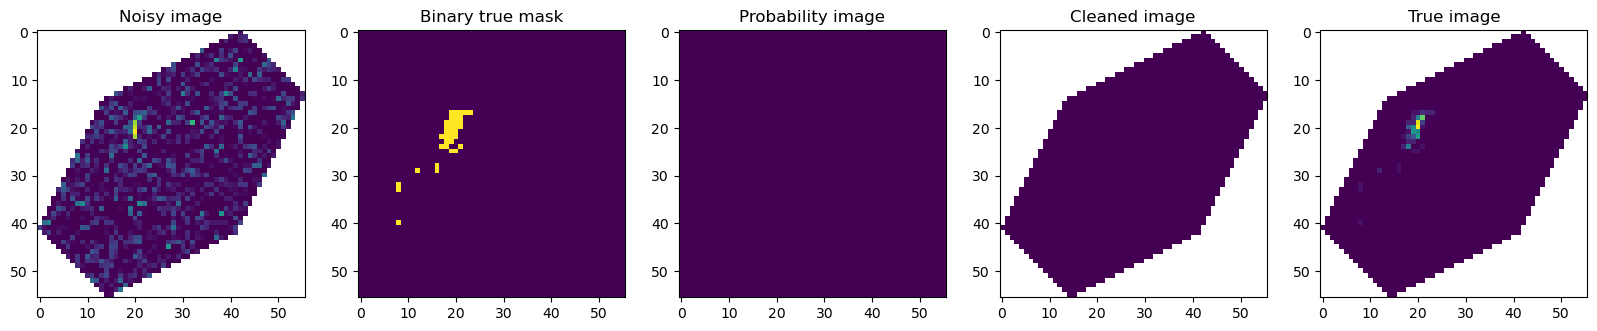

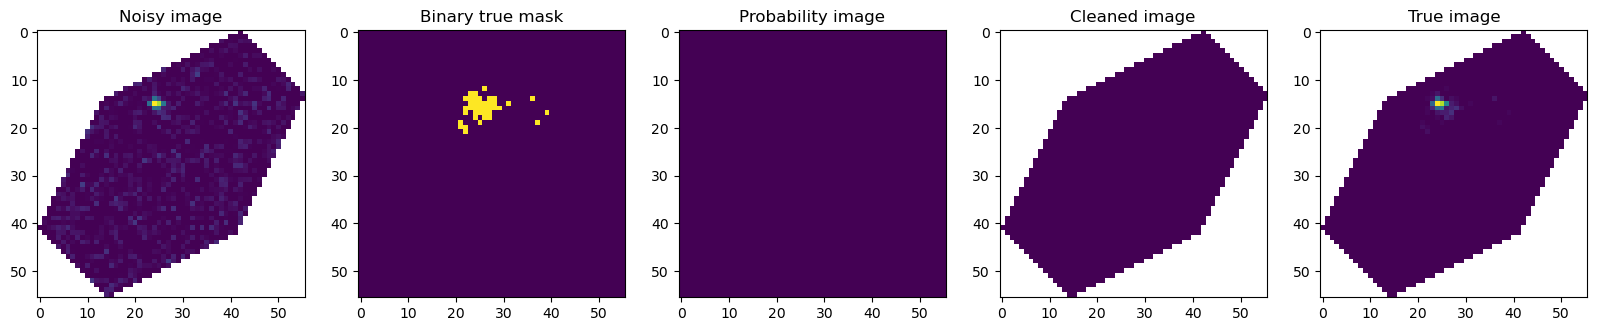

In [68]:
n_start = 0
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean_good[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,5,figsize=(20,10))

    axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
    axs[0].set_title("Noisy image")
    
    axs[1].imshow((data_true_binary[images_high_mask])[idx_split+im_i])
    axs[1].set_title("Binary true mask")
    
    fig_clean_prob = axs[2].imshow(im_clean_prob, vmin=0)
    axs[2].set_title("Probability image")

    axs[3].imshow(im_clean_good, vmin=0)
    axs[3].set_title("Cleaned image")

    axs[4].imshow(data_true_test_im[im_i], vmin=0)
    axs[4].set_title("True image")

plt.show()    

**2 layer**

In [69]:
%%time

learning_rate = 0.001

network = AE2()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*100 for i in range(n_epochs + 1)]
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)
IOU_all.append(IOU_list)


Test set: Avg. loss: 0.9034
IOU: 0.025318292900919914
Training set: Avg. loss: 0.2183

Test set: Avg. loss: 0.1112
IOU: 0.0002519738918635994
Training set: Avg. loss: 0.1309

Test set: Avg. loss: 0.1072
IOU: 0.0007843938656151295
Training set: Avg. loss: 0.1271

Test set: Avg. loss: 0.1018
IOU: 0.0007575235213153064
Training set: Avg. loss: 0.1238

Test set: Avg. loss: 0.1030
IOU: 0.0035908075515180826
Training set: Avg. loss: 0.1215

Test set: Avg. loss: 0.0979
IOU: 0.37019798159599304
Training set: Avg. loss: 0.1189

Test set: Avg. loss: 0.0975
IOU: 0.37635618448257446
Training set: Avg. loss: 0.1187

Test set: Avg. loss: 0.0969
IOU: 0.36710965633392334
Training set: Avg. loss: 0.1158

Test set: Avg. loss: 0.0948
IOU: 0.3825593888759613
Training set: Avg. loss: 0.1147

Test set: Avg. loss: 0.0964
IOU: 0.36407747864723206
Training set: Avg. loss: 0.1132

Test set: Avg. loss: 0.0925
IOU: 0.40216517448425293
Training set: Avg. loss: 0.1113

Test set: Avg. loss: 0.0918
IOU: 0.4007947444

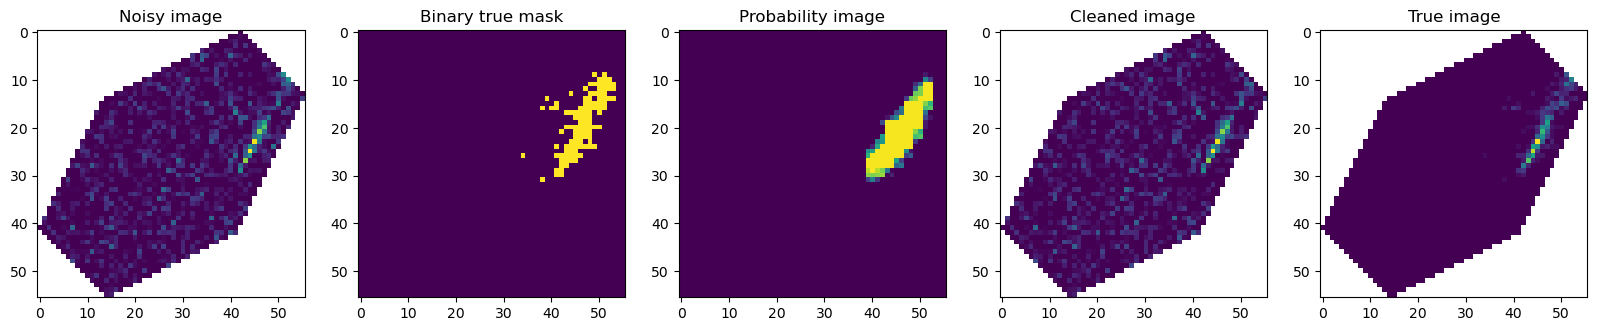

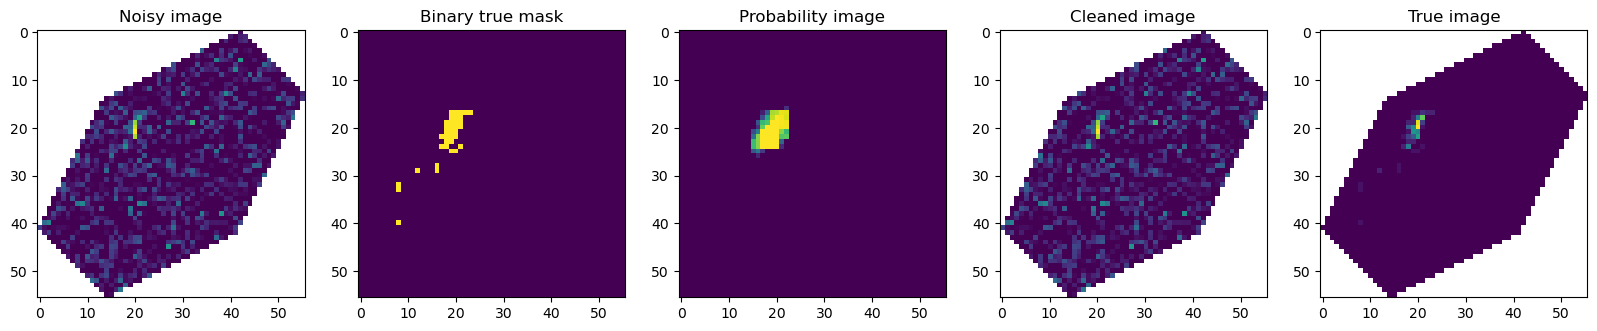

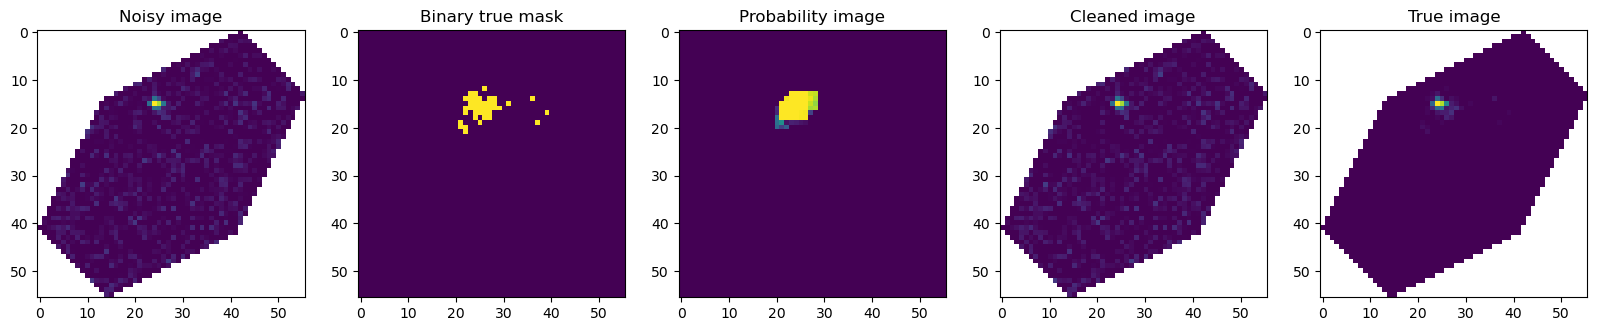

In [70]:
n_start = 0
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean_good[nan_mask] = np.nan
    
    # Obtain mask of true image
    
    #data_true_masked = data_true_tensor
    
    fig, axs = plt.subplots(1,5,figsize=(20,10))

    axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
    axs[0].set_title("Noisy image")
    
    axs[1].imshow((data_true_binary[images_high_mask])[idx_split+im_i])
    axs[1].set_title("Binary true mask")
    
    fig_clean_prob = axs[2].imshow(im_clean_prob, vmin=0)
    axs[2].set_title("Probability image")
    #plt.colorbar(fig_clean_prob, ax=axs[1])

    axs[3].imshow(im_clean_good, vmin=0)
    axs[3].set_title("Cleaned image")

    axs[4].imshow(data_true_test_im[im_i], vmin=0)
    axs[4].set_title("True image")

plt.show()    

**3 layers**

In [71]:
%%time

learning_rate = 0.001

network = AE3()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*100 for i in range(n_epochs + 1)]
IOU_list = []


test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)
IOU_all.append(IOU_list)


Test set: Avg. loss: 0.9348
IOU: 0.02486645057797432
Training set: Avg. loss: 0.2125

Test set: Avg. loss: 0.0986
IOU: 0.3506391644477844
Training set: Avg. loss: 0.1200

Test set: Avg. loss: 0.0960
IOU: 0.36838918924331665
Training set: Avg. loss: 0.1164

Test set: Avg. loss: 0.0956
IOU: 0.37135398387908936
Training set: Avg. loss: 0.1136

Test set: Avg. loss: 0.0964
IOU: 0.427022248506546
Training set: Avg. loss: 0.1112

Test set: Avg. loss: 0.0904
IOU: 0.41098442673683167
Training set: Avg. loss: 0.1087

Test set: Avg. loss: 0.0884
IOU: 0.4431779384613037
Training set: Avg. loss: 0.1062

Test set: Avg. loss: 0.0867
IOU: 0.4548770487308502
Training set: Avg. loss: 0.1052

Test set: Avg. loss: 0.0824
IOU: 0.4501427710056305
Training set: Avg. loss: 0.1002

Test set: Avg. loss: 0.0801
IOU: 0.46124351024627686
Training set: Avg. loss: 0.0960

Test set: Avg. loss: 0.0784
IOU: 0.4627787470817566
Training set: Avg. loss: 0.0959

Test set: Avg. loss: 0.0779
IOU: 0.4661967158317566
Training

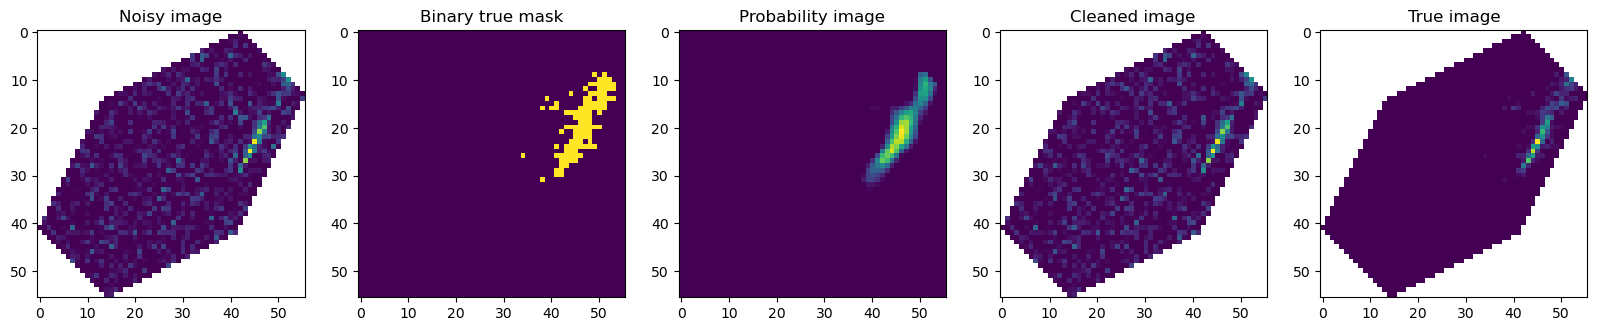

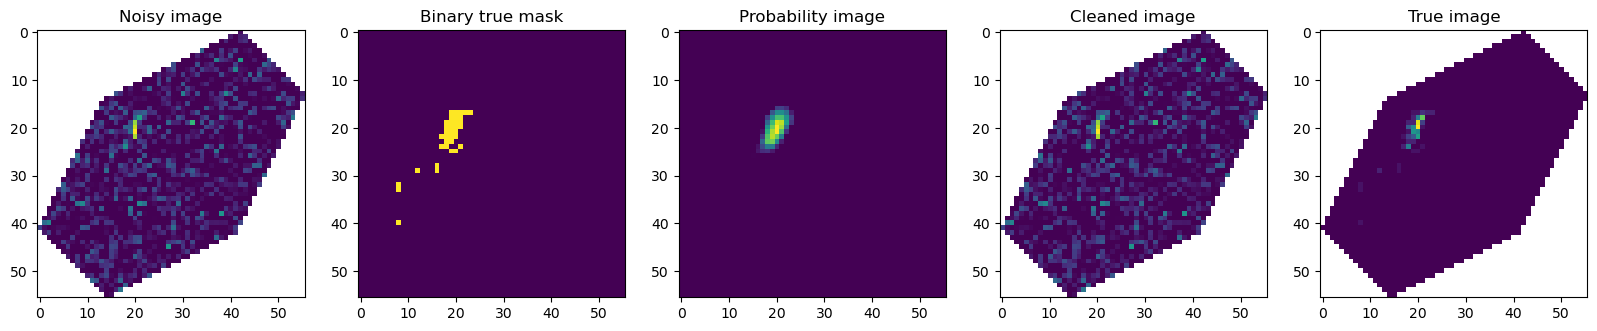

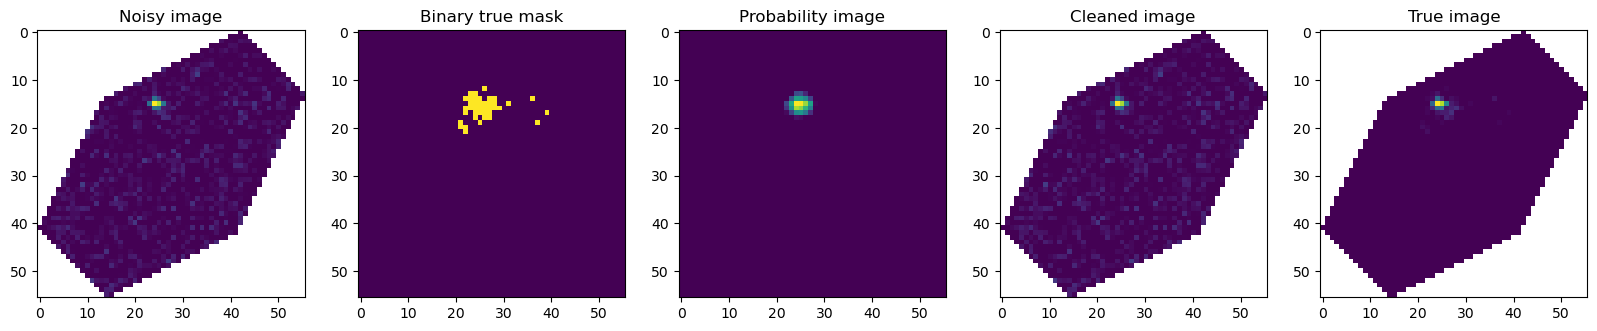

In [72]:
n_start = 0
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean_good[nan_mask] = np.nan
    
    # Obtain mask of true image
    
    #data_true_masked = data_true_tensor
    
    fig, axs = plt.subplots(1,5,figsize=(20,10))

    axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
    axs[0].set_title("Noisy image")
    
    axs[1].imshow((data_true_binary[images_high_mask])[idx_split+im_i])
    axs[1].set_title("Binary true mask")
    
    fig_clean_prob = axs[2].imshow(im_clean_prob, vmin=0)
    axs[2].set_title("Probability image")
    #plt.colorbar(fig_clean_prob, ax=axs[1])

    axs[3].imshow(im_clean_good, vmin=0)
    axs[3].set_title("Cleaned image")

    axs[4].imshow(data_true_test_im[im_i], vmin=0)
    axs[4].set_title("True image")

plt.show()    

**4 layers**

In [73]:
%%time

learning_rate = 0.001

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*100 for i in range(n_epochs + 1)]
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)
IOU_all.append(IOU_list)


Test set: Avg. loss: 0.9275
IOU: 0.02559220790863037
Training set: Avg. loss: 0.1890

Test set: Avg. loss: 0.0930
IOU: 0.35187220573425293
Training set: Avg. loss: 0.1099

Test set: Avg. loss: 0.0870
IOU: 0.3920409381389618
Training set: Avg. loss: 0.1020

Test set: Avg. loss: 0.0822
IOU: 0.42024898529052734
Training set: Avg. loss: 0.0978

Test set: Avg. loss: 0.0859
IOU: 0.4206370413303375
Training set: Avg. loss: 0.0942

Test set: Avg. loss: 0.0776
IOU: 0.4576176106929779
Training set: Avg. loss: 0.0925

Test set: Avg. loss: 0.0803
IOU: 0.4690590500831604
Training set: Avg. loss: 0.0900

Test set: Avg. loss: 0.0761
IOU: 0.47466564178466797
Training set: Avg. loss: 0.0885

Test set: Avg. loss: 0.0777
IOU: 0.46521323919296265
Training set: Avg. loss: 0.0928

Test set: Avg. loss: 0.0770
IOU: 0.4712730348110199
Training set: Avg. loss: 0.0882

Test set: Avg. loss: 0.0736
IOU: 0.4819534122943878
Training set: Avg. loss: 0.0863

Test set: Avg. loss: 0.0728
IOU: 0.4842577874660492
Trainin

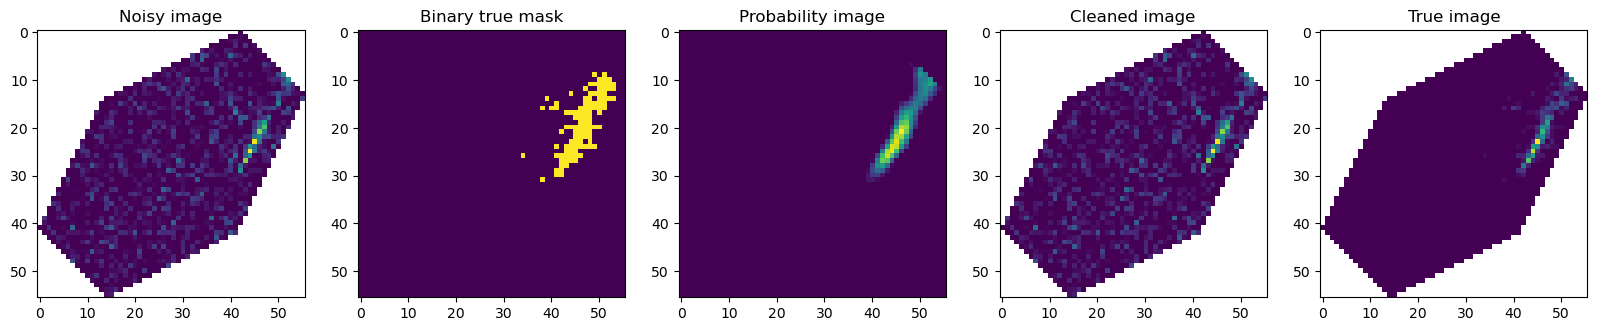

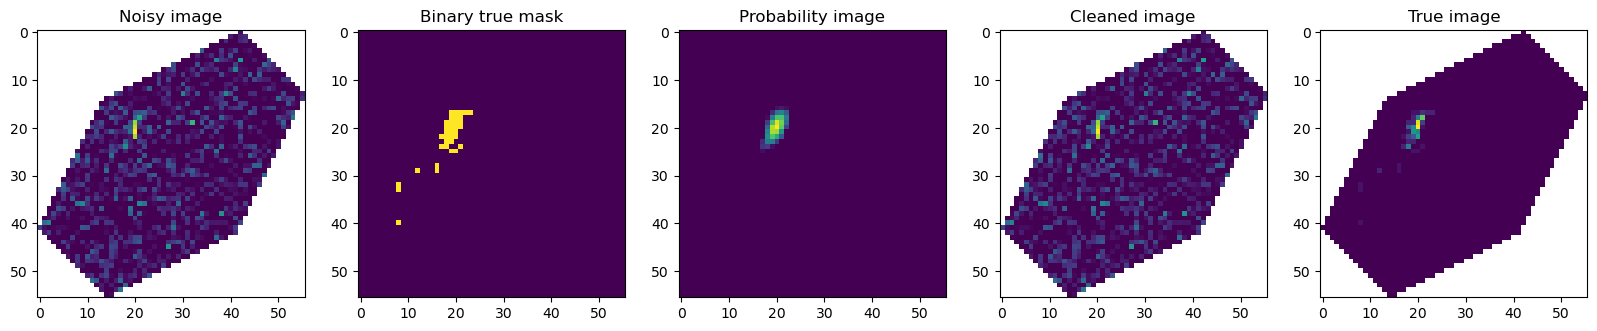

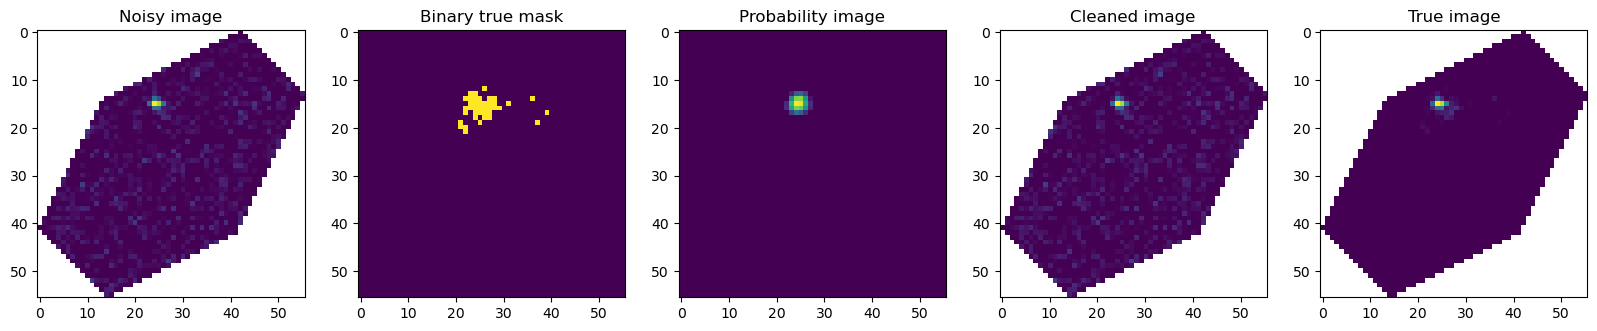

In [74]:
n_start = 0
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean_good[nan_mask] = np.nan
    
    # Obtain mask of true image
    
    #data_true_masked = data_true_tensor
    
    fig, axs = plt.subplots(1,5,figsize=(20,10))

    axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
    axs[0].set_title("Noisy image")
    
    axs[1].imshow((data_true_binary[images_high_mask])[idx_split+im_i])
    axs[1].set_title("Binary true mask")
    
    fig_clean_prob = axs[2].imshow(im_clean_prob, vmin=0)
    axs[2].set_title("Probability image")
    #plt.colorbar(fig_clean_prob, ax=axs[1])

    axs[3].imshow(im_clean_good, vmin=0)
    axs[3].set_title("Cleaned image")

    axs[4].imshow(data_true_test_im[im_i], vmin=0)
    axs[4].set_title("True image")

plt.show()    

**Comparing the architectures**

In [75]:
test_losses_arr = np.array(test_losses_all)
IOU_all_arr = np.array(IOU_all)

In [82]:
IOU_mean = np.mean(IOU_all_arr[:,-5:], axis=1)
IOU_std = np.std(IOU_all_arr[:,-5:], axis=1)

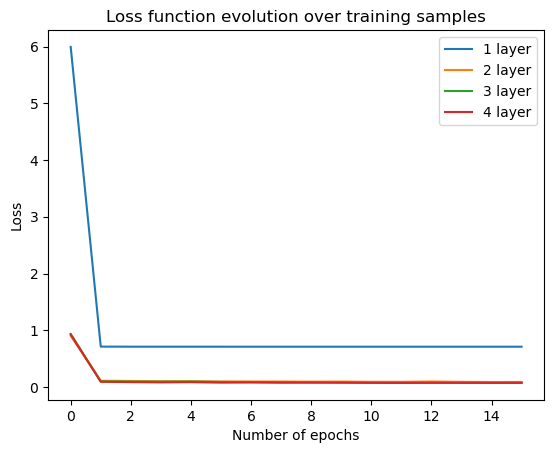

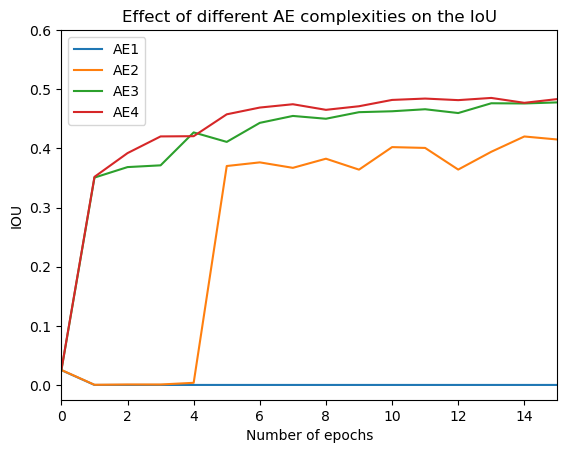

In [81]:
test_counter = np.linspace(0, n_epochs, n_epochs+1)

plt.figure()
plt.title("Loss function evolution over training samples")
plt.plot(test_counter, test_losses_arr[0], label='1 layer')
plt.plot(test_counter, test_losses_arr[1], label='2 layer')
plt.plot(test_counter, test_losses_arr[2], label='3 layer')
plt.plot(test_counter, test_losses_arr[3], label='4 layer')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.title("Effect of different AE complexities on the IoU")
plt.plot(test_counter, IOU_all_arr[0], label='AE1')
plt.plot(test_counter, IOU_all_arr[1], label='AE2')
plt.plot(test_counter, IOU_all_arr[2], label='AE3')
plt.plot(test_counter, IOU_all_arr[3], label='AE4')
plt.xlim(0,n_epochs)
plt.ylim(-0.025, 0.6)
plt.xlabel("Number of epochs")
plt.ylabel("IOU")
plt.legend()
plt.show()

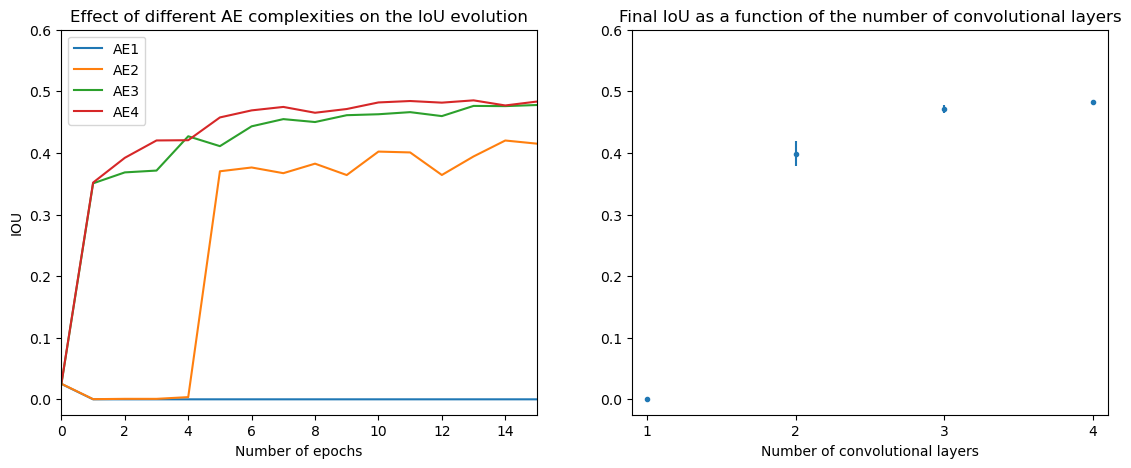

In [88]:
# Plot the fitting results as the loss function and the IoU

fig_layers, axs = plt.subplots(1, 2, figsize=(13.5,5))

axs[0].set_title("Effect of different AE complexities on the IoU evolution")
axs[0].plot(test_counter, IOU_all_arr[0], label='AE1')
axs[0].plot(test_counter, IOU_all_arr[1], label='AE2')
axs[0].plot(test_counter, IOU_all_arr[2], label='AE3')
axs[0].plot(test_counter, IOU_all_arr[3], label='AE4')
axs[0].set_xlim(0,n_epochs)
axs[0].set_ylim(-0.025, 0.6)
axs[0].set_xlabel("Number of epochs")
axs[0].set_ylabel("IOU")
axs[0].legend()

axs[1].set_title("Final IoU as a function of the number of convolutional layers")
axs[1].errorbar(np.array([1,2,3,4]), np.mean(IOU_all_arr[:, -5:], axis=1), yerr=np.std(IOU_all_arr[:, -5:], axis=1), fmt='.')
axs[1].set_xlabel("Number of convolutional layers")
#axs[1].set_ylabel("IoU")
axs[1].set_xlim(0.9, 4.1)
#axs[1].legend()
axs[1].set_ylim(-0.025,0.6)
axs[1].set_xticks([1,2,3,4], [1,2,3,4])

plt.show()

fig_layers.savefig("images/architectures_plot.pdf")